# Poisson Process for Fraud Modeling

Author: https://github.com/deburky

This notebook explores the use of Poisson, Negative Binomial, tree-based (XGBoost, CatBoost) models to predict daily fraud counts.

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from matplotlib import pyplot as plt
from scipy.stats import nbinom, poisson
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'

## Negative Binomial Fit

Mean: 0.09433040078335007, Variance: 0.2067453460386657, Alpha: 12.633413003277061, R: 0.07915517364473112, P: 0.45626372051784087


/var/folders/k_/yz8rvp25185_js60dw8vhnj40000gn/T/ipykernel_18123/983341333.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df["Hour"] = df["TransactionStartTime"].dt.floor("H")
/Users/deburky/Documents/python/python-ml-projects/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


,FraudCount (k),Actual Frequency,NB Predicted Frequency,Actual Probability,NB Probability
FraudCount,,,,,
0,0,1924,1923.0,0.9404,0.9398
1,1,82,83.0,0.0401,0.0404
2,2,23,24.0,0.0112,0.0119
3,3,9,9.0,0.0044,0.0045
4,4,4,4.0,0.0020,0.0019
5,5,2,2.0,0.0010,0.0008
6,6,2,1.0,0.0010,0.0004


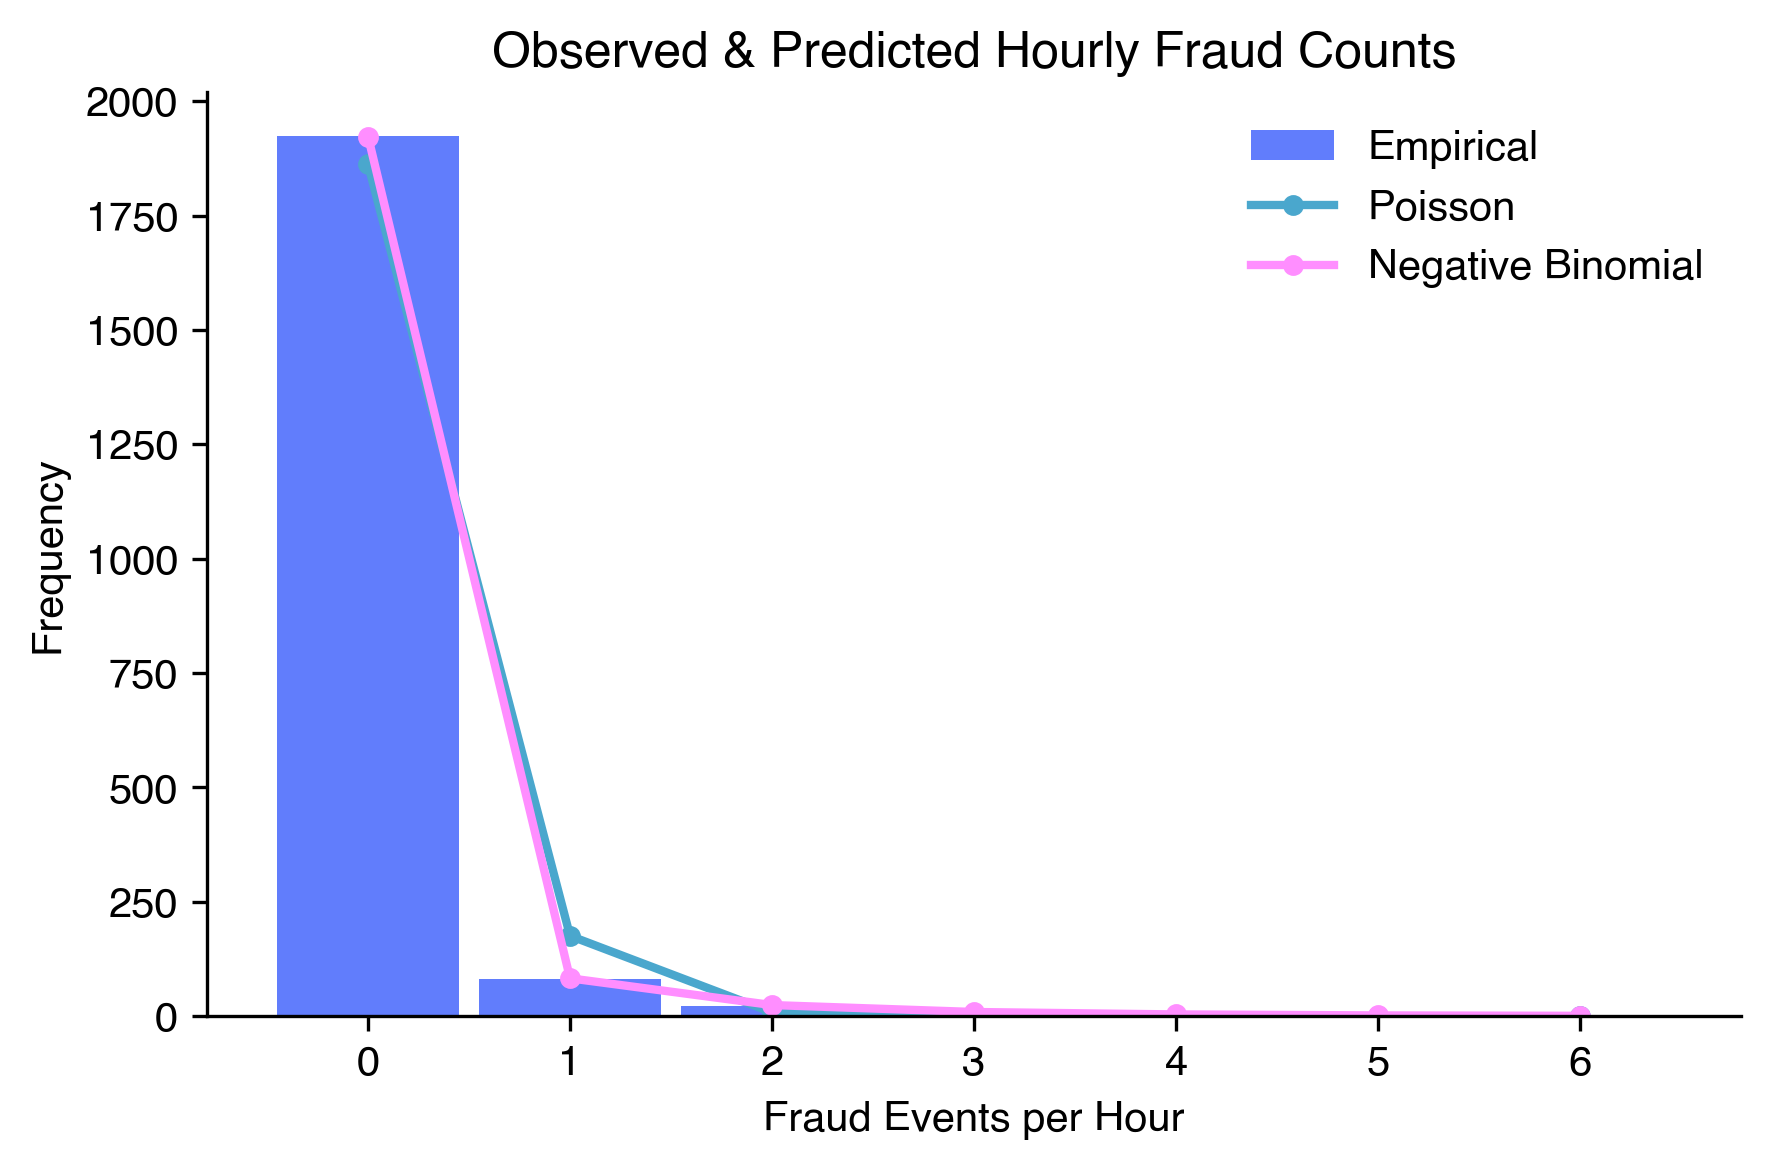

In [2]:
# Load data
ROOT_DIR = Path.cwd()
DATA_DIR = ROOT_DIR / "datasets" / "Xente"
df = pd.read_csv(DATA_DIR / "bnpl_data.csv", parse_dates=["TransactionStartTime"])

df["Hour"] = df["TransactionStartTime"].dt.floor("H")

# Aggregate fraud events by hour
hourly_fraud_counts = df.groupby("Hour")["FraudResult"].sum().reset_index()
hourly_fraud_counts.rename(columns={"FraudResult": "FraudCount"}, inplace=True)

# Fit Poisson model
lambda_hourly = hourly_fraud_counts["FraudCount"].mean()

# Empirical probabilities
p0_empirical = (hourly_fraud_counts["FraudCount"] == 0).mean()
p1_empirical = (hourly_fraud_counts["FraudCount"] == 1).mean()
p_gt1_empirical = (hourly_fraud_counts["FraudCount"] > 1).mean()

# Poisson probabilities
p0_poisson = poisson.pmf(0, mu=lambda_hourly)
p1_poisson = poisson.pmf(1, mu=lambda_hourly)
p_gt1_poisson = 1 - (p0_poisson + p1_poisson)

# Fit Negative Binomial model (intercept only)
hourly_fraud_counts["Intercept"] = 1
nb_model = sm.GLM(
    hourly_fraud_counts["FraudCount"],
    hourly_fraud_counts[["Intercept"]],
    family=sm.families.NegativeBinomial(),
).fit()

# Estimate NB parameters
mu_nb = nb_model.mu
var_nb = hourly_fraud_counts["FraudCount"].var()
alpha = (var_nb - mu_nb.mean()) / (mu_nb.mean() ** 2)
r = 1 / alpha
p = r / (r + mu_nb.mean())

print(f"Mean: {mu_nb.mean()}, Variance: {var_nb}, Alpha: {alpha}, R: {r}, P: {p}")

# Comparison table
k_values = np.arange(0, hourly_fraud_counts["FraudCount"].max() + 1)
actual_freq = (
    hourly_fraud_counts["FraudCount"]
    .value_counts()
    .sort_index()
    .reindex(k_values, fill_value=0)
)
nb_probabilities = nbinom.pmf(k_values, r, p)
nb_freq = nb_probabilities * len(hourly_fraud_counts)

poisson_probabilities = poisson.pmf(k_values, mu=lambda_hourly)
poisson_freq = poisson_probabilities * len(hourly_fraud_counts)

comparison_df = pd.DataFrame(
    {
        "FraudCount (k)": k_values,
        "Actual Frequency": actual_freq.values,
        # "Poisson Predicted Frequency": poisson_freq.round(0),
        "NB Predicted Frequency": nb_freq.round(0),
        "Actual Probability": (actual_freq / len(hourly_fraud_counts)).round(4),
        # "Poisson Probability": poisson_probabilities.round(4),
        "NB Probability": nb_probabilities.round(4),
    }
)

display(comparison_df)

# set font to Avenir
plt.rcParams["font.family"] = "Helvetica"
colors = ["#3A5DFC", "#4AA7CD", "#FF8EFF"]

# Plot histogram comparison
plt.figure(figsize=(6, 4), dpi=150)
ax = plt.gca()

# Set inner plot background
# ax.set_facecolor("#B1F097")
plt.hist(
    hourly_fraud_counts["FraudCount"],
    bins=range(0, hourly_fraud_counts["FraudCount"].max() + 2),
    align="left",
    rwidth=0.9,
    alpha=0.8,
    label="Empirical",
    color=colors[0],
)
poisson_pmf = poisson.pmf(k_values, mu=lambda_hourly) * len(hourly_fraud_counts)
plt.plot(
    k_values,
    poisson_pmf,
    color=colors[1],
    label="Poisson",
    linewidth=2,
    marker="o",
    markersize=4,
)
plt.plot(
    k_values,
    nb_freq,
    color=colors[2],
    label="Negative Binomial",
    linewidth=2,
    marker="o",
    markersize=4,
)
# Disable spines
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# Set tick parameters

plt.xlabel("Fraud Events per Hour")
plt.ylabel("Frequency")
plt.title("Observed & Predicted Hourly Fraud Counts")
plt.legend(facecolor="white", framealpha=1, frameon=False)
plt.grid(False)
plt.tight_layout()
plt.savefig("fraud_model_comparison.png")

## Time projection

In [3]:
def calculate_chi_square(actual, predicted):
    """Calculate chi-square statistic."""
    return np.sum((actual - predicted) ** 2 / predicted)

### Full dataset

/Users/deburky/Documents/python/python-ml-projects/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


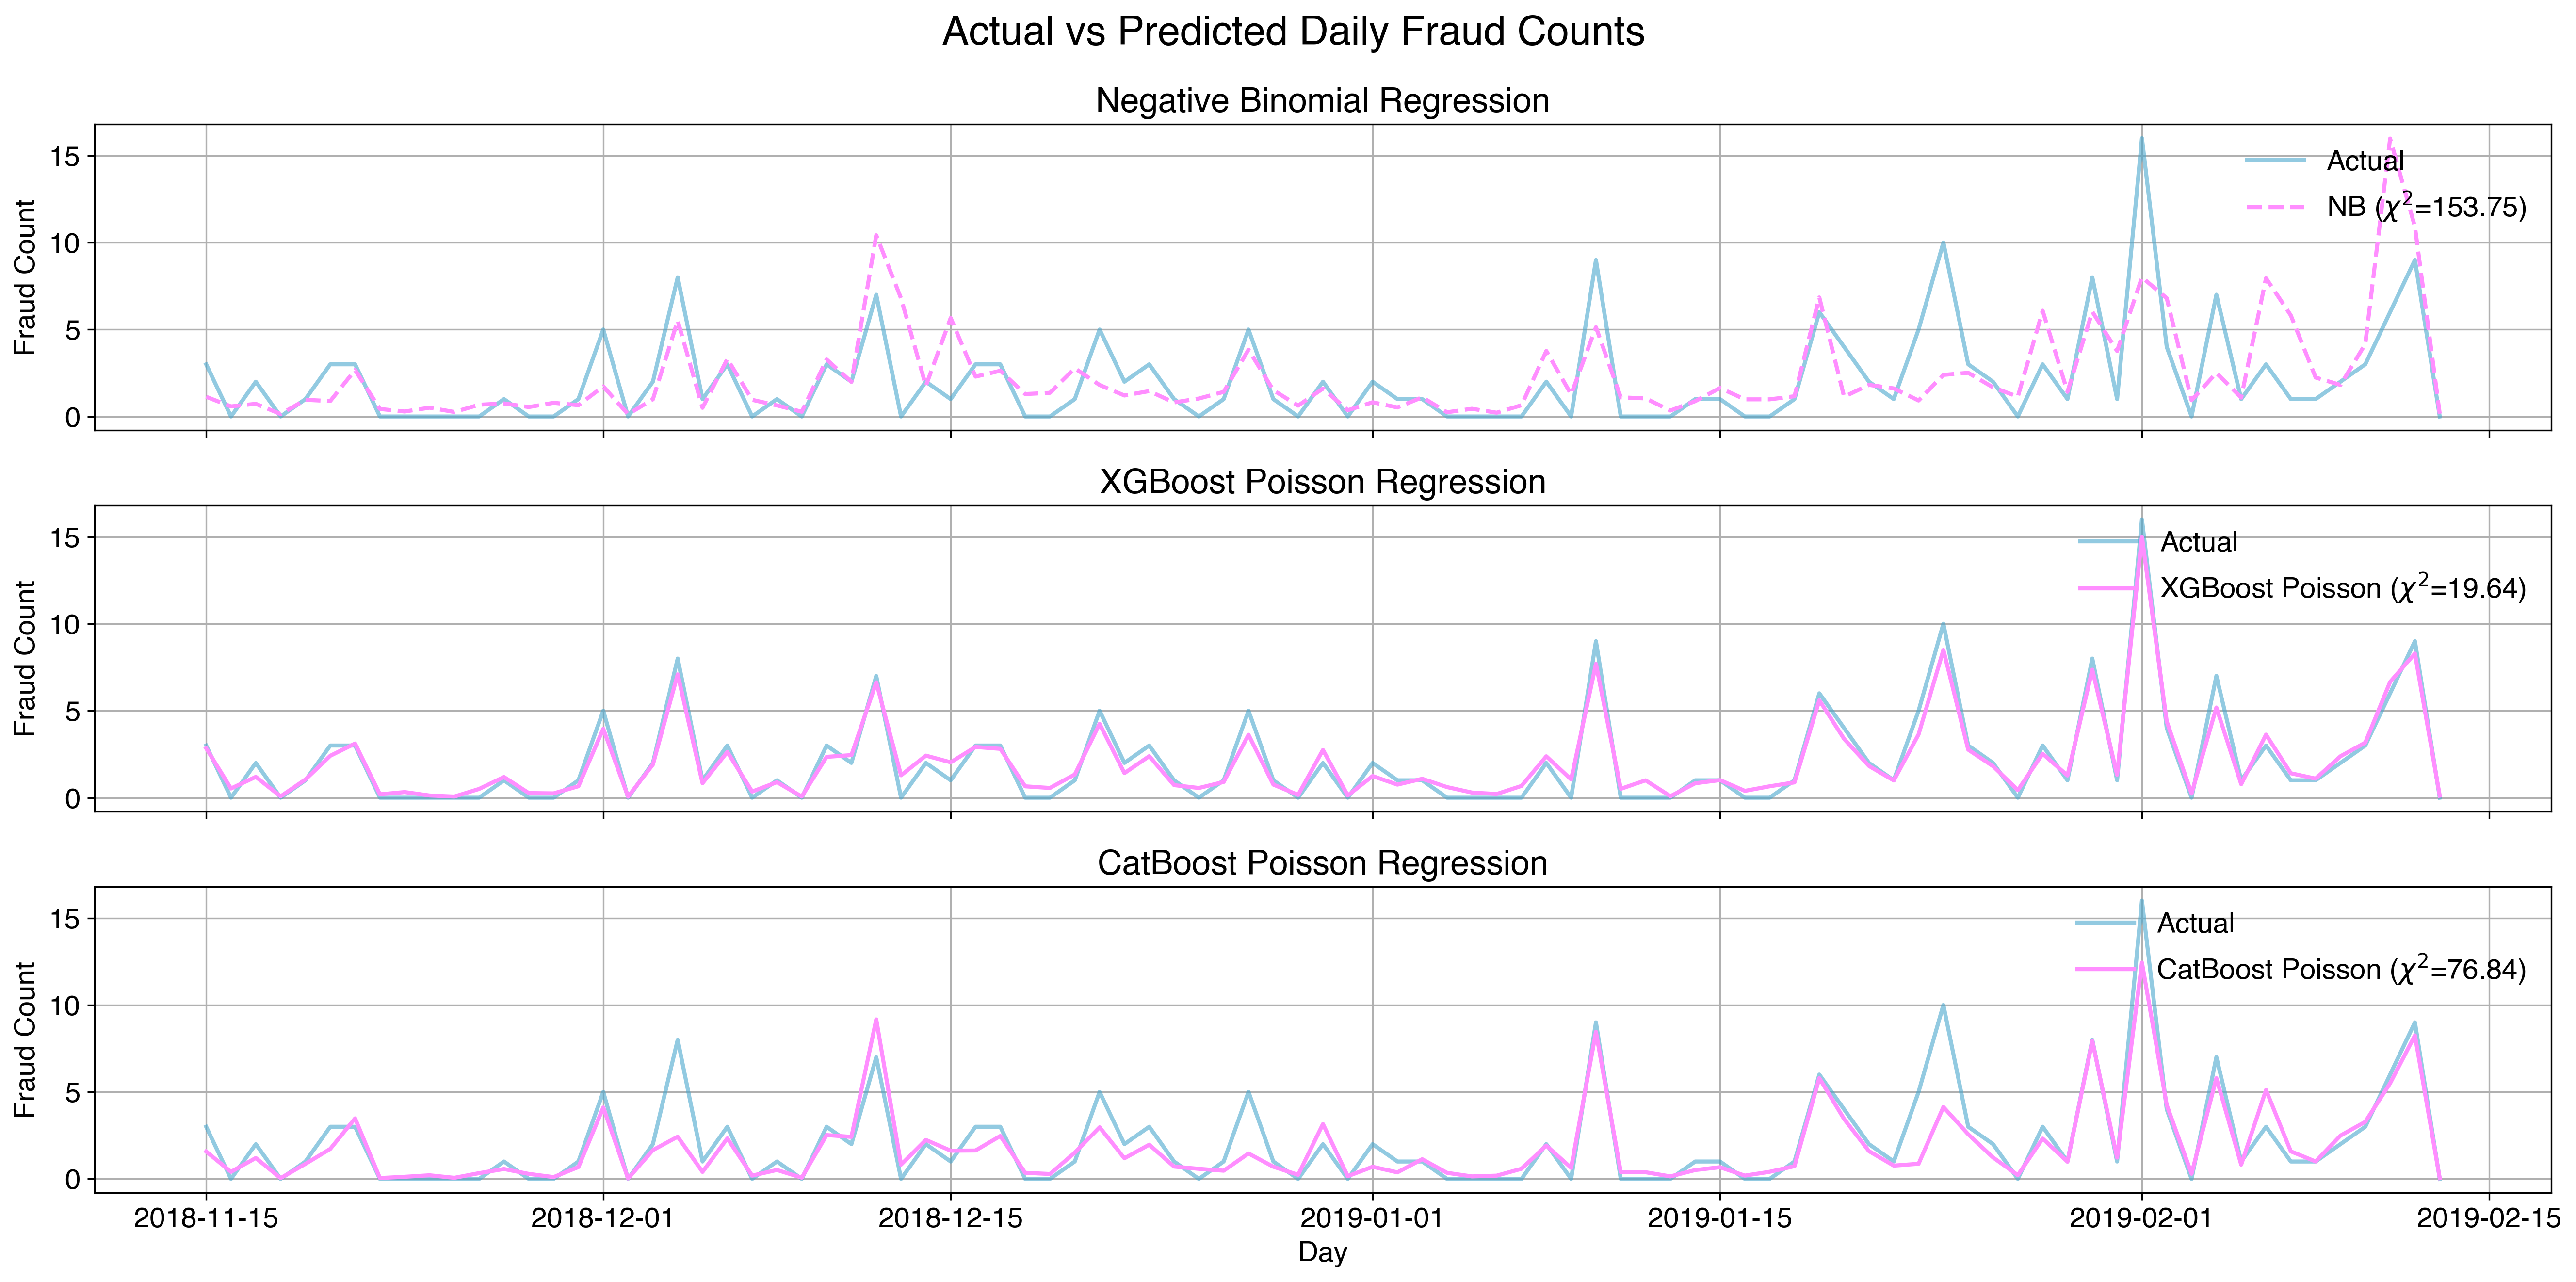

In [4]:
# set font to 14
plt.rcParams["font.size"] = 14

# Aggregate to daily level
base_df = (
    df.groupby(df["TransactionStartTime"].dt.floor("D"))
    .agg(
        FraudCount=("FraudResult", "sum"),
        TxCount=("FraudResult", "count"),
        AvgAmount=("Amount", "mean"),
        AvgValue=("Value", "mean"),
    )
    .reset_index()
    .rename(columns={"TransactionStartTime": "Day"})
)

# Feature Engineering
base_df["Weekday"] = base_df["Day"].dt.weekday
base_df["AvgAmount"] = base_df["AvgAmount"].clip(lower=1e-2)
base_df["AvgValue"] = base_df["AvgValue"].clip(lower=1e-2)
base_df["TxCount"] = base_df["TxCount"].clip(lower=1e-2)
base_df["LogAmount"] = np.log(base_df["AvgAmount"])
base_df["LogValue"] = np.log(base_df["AvgValue"])
base_df["LogTxCount"] = np.log(base_df["TxCount"])

# Copy once for predictions
results_df = base_df.copy()

# Negative Binomial
nb_model = smf.glm(
    formula="FraudCount ~ LogTxCount + LogAmount + LogValue + C(Weekday)",
    data=base_df,
    family=sm.families.NegativeBinomial(),
).fit()
results_df["NB_Pred"] = nb_model.predict(base_df)
nb_chi = calculate_chi_square(results_df["FraudCount"], results_df["NB_Pred"])

# XGBoost
X_xgb = base_df[["LogTxCount", "LogAmount", "LogValue", "Weekday"]]
y_xgb = base_df["FraudCount"]
X_xgb = pd.get_dummies(X_xgb, columns=["Weekday"], drop_first=True)
xgb_model = xgb.XGBRegressor(
    objective="count:poisson",
    eval_metric="rmse",
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
xgb_model.fit(X_xgb, y_xgb)
results_df["XGB_Pred"] = xgb_model.predict(X_xgb)
xgb_chi = calculate_chi_square(results_df["FraudCount"], results_df["XGB_Pred"])

# CatBoost
X_cb = base_df[["LogTxCount", "LogAmount", "LogValue", "Weekday"]]
y_cb = base_df["FraudCount"]
cat_features = [X_cb.columns.get_loc("Weekday")]
cat_model = CatBoostRegressor(
    loss_function="Poisson",
    iterations=200,
    learning_rate=0.1,
    depth=4,
    random_seed=42,
    verbose=0,
    allow_writing_files=False,
)
cat_model.fit(Pool(X_cb, y_cb, cat_features=cat_features))
results_df["CAT_Pred"] = cat_model.predict(Pool(X_cb, cat_features=cat_features))
cat_chi = calculate_chi_square(results_df["FraudCount"], results_df["CAT_Pred"])

# Plot in Grid (1 column x 3 rows)
fig, axs = plt.subplots(3, 1, figsize=(18, 9), dpi=150, sharex=True)
colors = ["#4AA7CD", "#FF8EFF"]

# Negative Binomial
axs[0].plot(
    results_df["Day"],
    results_df["FraudCount"],
    label="Actual",
    color=colors[0],
    linewidth=2,
    alpha=0.6,
)
axs[0].plot(
    results_df["Day"],
    results_df["NB_Pred"],
    label=rf"NB ($\chi^2$={nb_chi:.2f})",
    color=colors[1],
    linestyle="--",
    linewidth=2,
)
axs[0].set_title("Negative Binomial Regression")
axs[0].legend(loc="upper right", framealpha=1, frameon=False)
axs[0].grid(True)

# XGBoost
axs[1].plot(
    results_df["Day"],
    results_df["FraudCount"],
    label="Actual",
    color=colors[0],
    linewidth=2,
    alpha=0.6,
)
axs[1].plot(
    results_df["Day"],
    results_df["XGB_Pred"],
    label=rf"XGBoost Poisson ($\chi^2$={xgb_chi:.2f})",
    color=colors[1],
    linewidth=2,
)
axs[1].set_title("XGBoost Poisson Regression")
axs[1].legend(loc="upper right", framealpha=1, frameon=False)
axs[1].grid(True)

# CatBoost
axs[2].plot(
    results_df["Day"],
    results_df["FraudCount"],
    label="Actual",
    color=colors[0],
    linewidth=2,
    alpha=0.6,
)
axs[2].plot(
    results_df["Day"],
    results_df["CAT_Pred"],
    label=rf"CatBoost Poisson ($\chi^2$={cat_chi:.2f})",
    color=colors[1],
    linewidth=2,
)
axs[2].set_title("CatBoost Poisson Regression")
axs[2].legend(loc="upper right", framealpha=1, frameon=False)
axs[2].grid(True)

# Final layout
axs[2].set_xlabel("Day")
for ax in axs:
    ax.set_ylabel("Fraud Count")

plt.suptitle("Actual vs Predicted Daily Fraud Counts", fontsize=20, y=0.98)
plt.tight_layout()
plt.show()

### Partitioned dataset

/Users/deburky/Documents/python/python-ml-projects/.venv/lib/python3.11/site-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "


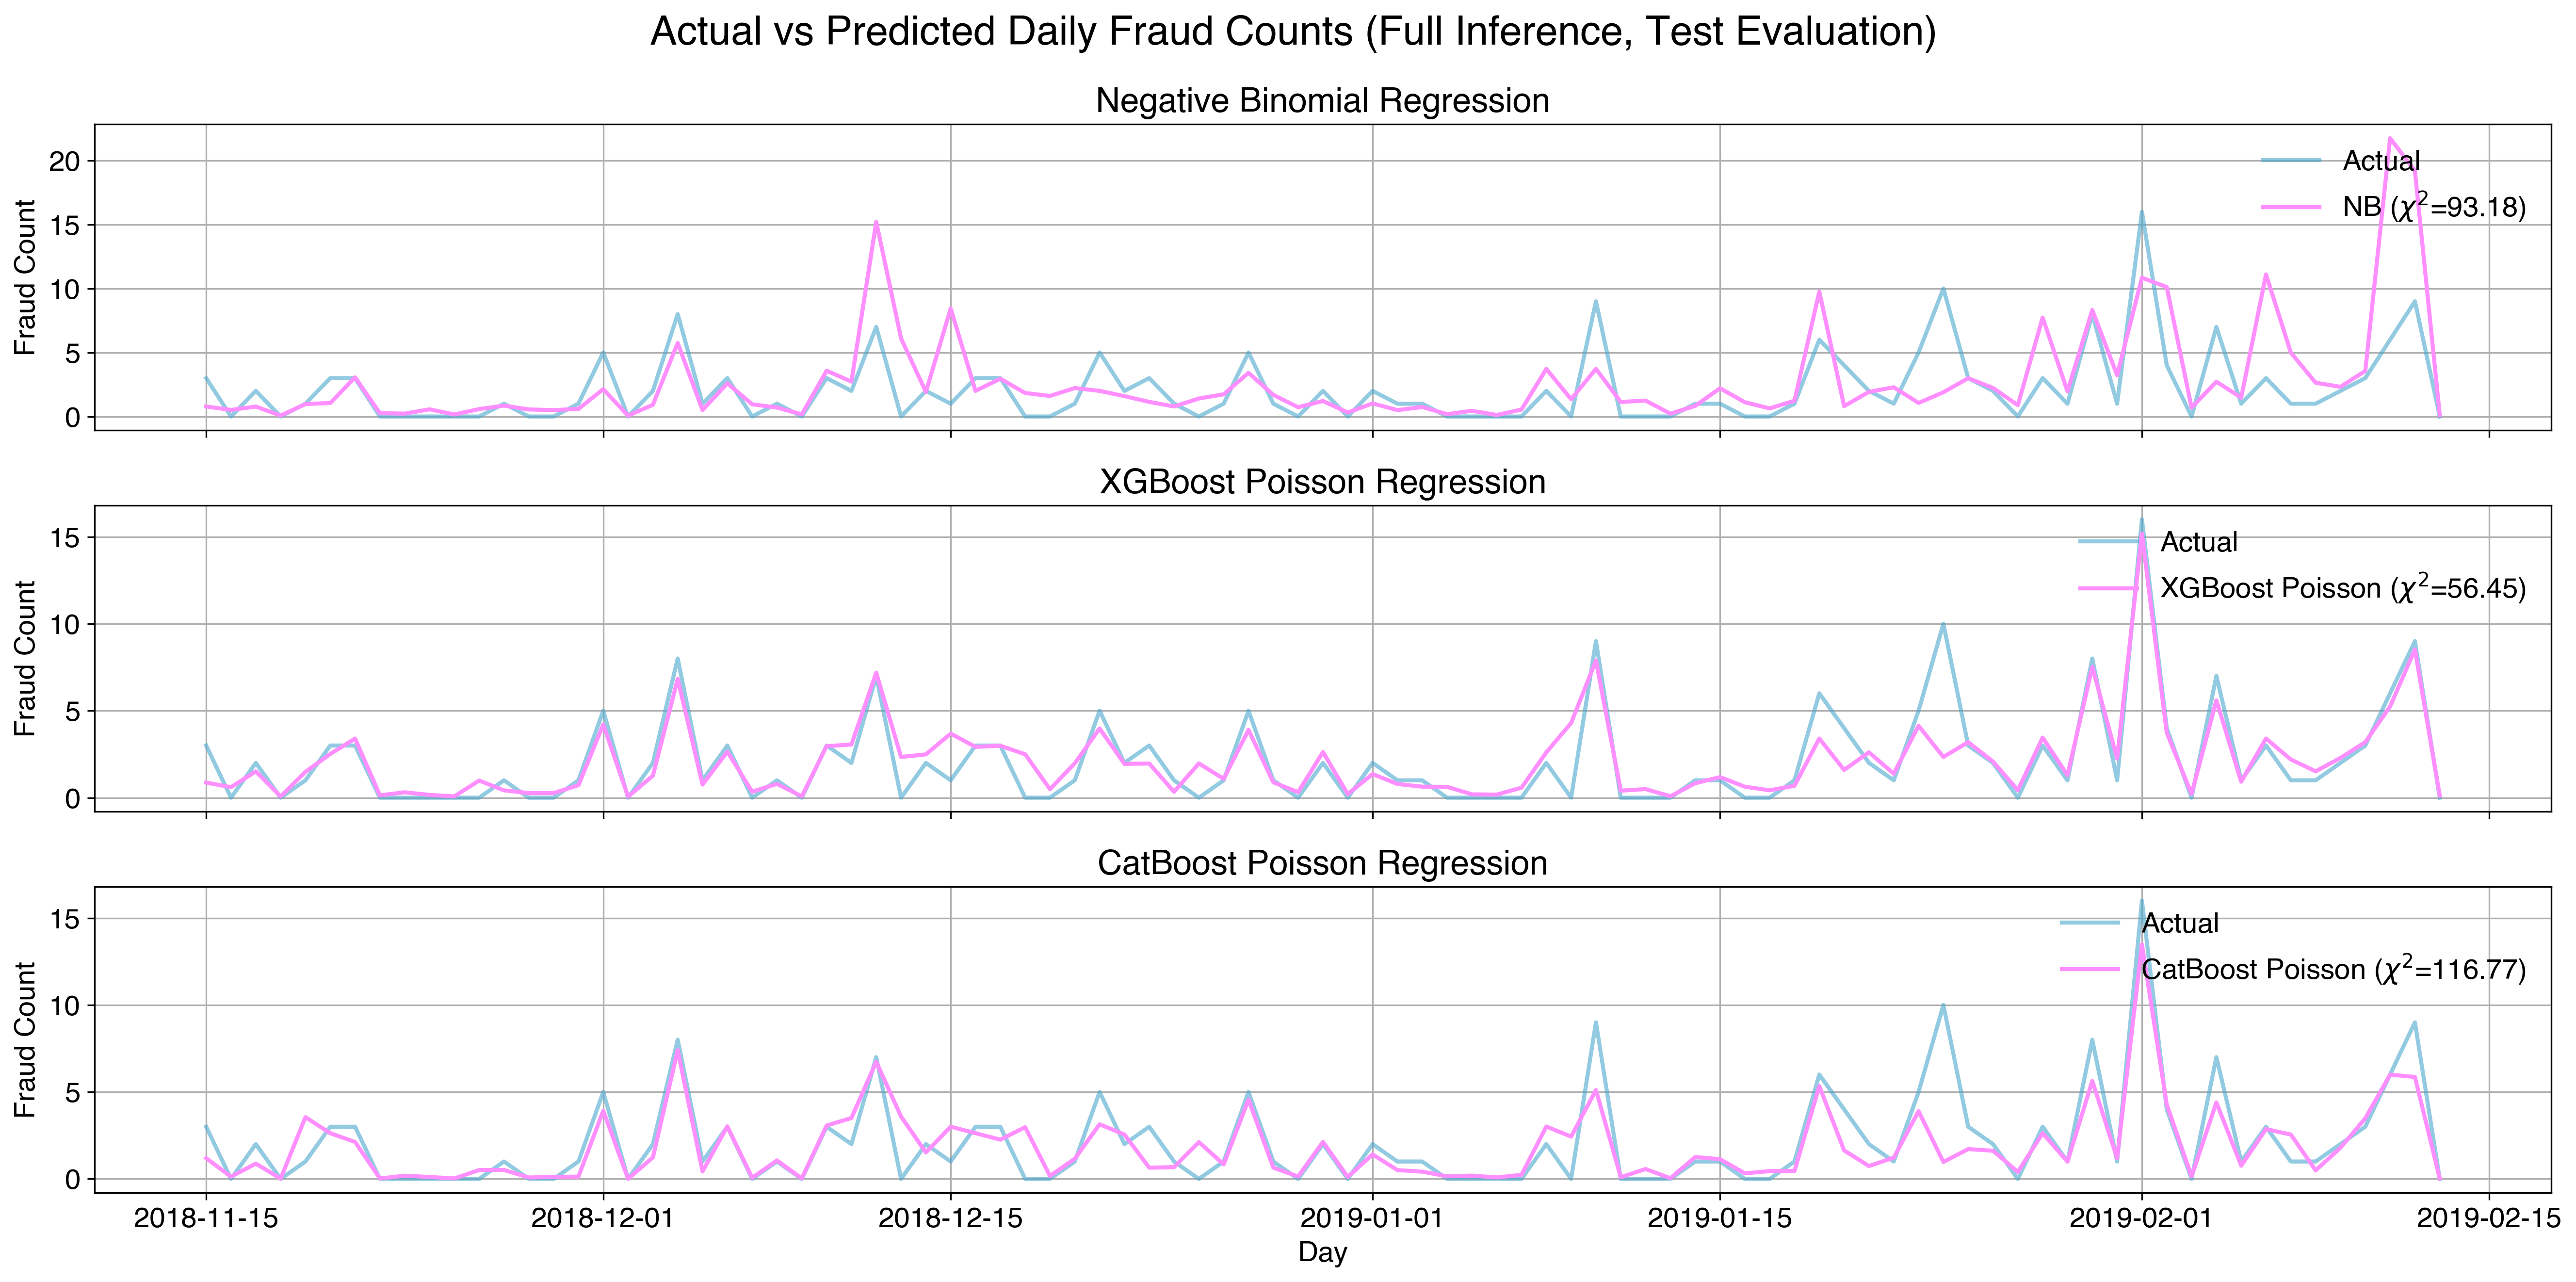

In [5]:
# Split data
train_df, _ = train_test_split(base_df, test_size=0.3, shuffle=True, random_state=42)
train_idx = train_df.index
test_idx = base_df.index.difference(train_idx)

# Negative Binomial
nb_model = smf.glm(
    formula="FraudCount ~ LogTxCount + LogAmount + LogValue + C(Weekday)",
    data=base_df.loc[train_idx],
    family=sm.families.NegativeBinomial(),
).fit()
base_df["NB_Pred"] = nb_model.predict(base_df)

# XGBoost (train on train_idx, predict on full)
X = base_df[["LogTxCount", "LogAmount", "LogValue", "Weekday"]]
y = base_df["FraudCount"]
X = pd.get_dummies(X, columns=["Weekday"], drop_first=True)

X_train = X.loc[train_idx]
y_train = y.loc[train_idx]

xgb_model = xgb.XGBRegressor(
    objective="count:poisson",
    eval_metric="rmse",
    max_depth=4,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
)
xgb_model.fit(X_train, y_train)
base_df["XGB_Pred"] = xgb_model.predict(X)

# CatBoost (train on train_idx, predict on full)
X_cb = base_df[["LogTxCount", "LogAmount", "LogValue", "Weekday"]]
y_cb = base_df["FraudCount"]
X_train_cb = X_cb.loc[train_idx]
y_train_cb = y_cb.loc[train_idx]
cat_features = [X_cb.columns.get_loc("Weekday")]

cat_model = CatBoostRegressor(
    loss_function="Poisson",
    iterations=200,
    learning_rate=0.1,
    depth=4,
    random_seed=42,
    verbose=0,
    allow_writing_files=False,
)
cat_model.fit(Pool(X_train_cb, y_train_cb, cat_features=cat_features))
base_df["CAT_Pred"] = cat_model.predict(Pool(X_cb, cat_features=cat_features))

# Chi-square on test
nb_chi = calculate_chi_square(
    base_df.loc[test_idx, "FraudCount"], base_df.loc[test_idx, "NB_Pred"]
)
xgb_chi = calculate_chi_square(
    base_df.loc[test_idx, "FraudCount"], base_df.loc[test_idx, "XGB_Pred"]
)
cat_chi = calculate_chi_square(
    base_df.loc[test_idx, "FraudCount"], base_df.loc[test_idx, "CAT_Pred"]
)

# Plot Results
fig, axs = plt.subplots(3, 1, figsize=(18, 9), dpi=150, sharex=True)
colors = ["#4AA7CD", "#FF8EFF"]

# NB Plot
axs[0].plot(
    base_df["Day"],
    base_df["FraudCount"],
    label="Actual",
    color=colors[0],
    linewidth=2,
    alpha=0.6,
)
axs[0].plot(
    base_df["Day"],
    base_df["NB_Pred"],
    label=rf"NB ($\chi^2$={nb_chi:.2f})",
    color=colors[1],
    linewidth=2,
)
axs[0].set_title("Negative Binomial Regression")
axs[0].legend(loc="upper right", framealpha=1, frameon=False)
axs[0].grid(True)

# XGBoost Plot
axs[1].plot(
    base_df["Day"],
    base_df["FraudCount"],
    label="Actual",
    color=colors[0],
    linewidth=2,
    alpha=0.6,
)
axs[1].plot(
    base_df["Day"],
    base_df["XGB_Pred"],
    label=rf"XGBoost Poisson ($\chi^2$={xgb_chi:.2f})",
    color=colors[1],
    linewidth=2,
)
axs[1].set_title("XGBoost Poisson Regression")
axs[1].legend(loc="upper right", framealpha=1, frameon=False)
axs[1].grid(True)

# CatBoost Plot
axs[2].plot(
    base_df["Day"],
    base_df["FraudCount"],
    label="Actual",
    color=colors[0],
    linewidth=2,
    alpha=0.6,
)
axs[2].plot(
    base_df["Day"],
    base_df["CAT_Pred"],
    label=rf"CatBoost Poisson ($\chi^2$={cat_chi:.2f})",
    color=colors[1],
    linewidth=2,
)
axs[2].set_title("CatBoost Poisson Regression")
axs[2].legend(loc="upper right", framealpha=1, frameon=False)
axs[2].grid(True)

# Final touches
axs[2].set_xlabel("Day")
for ax in axs:
    ax.set_ylabel("Fraud Count")

plt.suptitle(
    "Actual vs Predicted Daily Fraud Counts (Full Inference, Test Evaluation)",
    fontsize=20,
    y=0.98,
)
plt.tight_layout()
plt.show()